- [1. Importing Packages and Dataset](#1)
- [2. Assembling Datasets and Data Cleaning](#2)

## 1. Importing Packages and Dataset <a id='1'></a>

In [2]:
## Import desired packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import statsmodels.api as sm
import gc

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, silhouette_score, f1_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

# To graph heikin ashi
import mplfinance as mpf
from mpl_finance import candlestick_ohlc
import matplotlib

from tqdm import tqdm
import itertools
import gc
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
# Alpaca
import alpaca_trade_api as tradeapi

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [4]:
## Adding a method for future use
def add_macd(df):
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    # Calculate the 26-day EMA
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    # Calculate the MACD line
    macd_line = ema_12 - ema_26
    # Calculate the 9-day EMA of the MACD line
    signal_line = macd_line.ewm(span=9, adjust=False).mean()

    # Add the MACD and signal lines as new columns to the dataframe
    df['MACD'] = macd_line
    df['Signal Line'] = signal_line
    return df

def add_heiking_ashi(df):
    """ Assuming the column names are as below"""
    ## We are adding heikin ashi candle prices with a new dataframe
    temp = df.copy()
    # Heiking ashi candle prices
    temp['ha_close'] = (temp['open'] + temp['high'] + temp['low'] + temp['close'])/4
    temp['ha_open'] = (temp['open'].shift(1) + temp['close'].shift(1))/2
    temp['ha_high'] = temp[['high', 'ha_open', 'ha_close']].max(axis=1)
    temp['ha_low'] = temp[['low', 'ha_open', 'ha_close']].min(axis=1)
    return temp

def resample_for_crypto(df, time_interval):
    """
    Assuming the column names are "open", "close", "low", "high", and "Volume BTC"
    """
    ## Need to change the column variable for volumn
    ti = time_interval
    df_ti = df.resample(ti).mean()
    
    ti_open = df['open'].resample(ti).first()
    ti_close = bitcoin_df['close'].resample(ti).last()
    ti_high = bitcoin_df['high'].resample(ti).max()
    ti_low = bitcoin_df['low'].resample(ti).min()
    ti_volume = bitcoin_df['Volume BTC'].resample(ti).sum()

    df_ti['open'] = ti_open
    df_ti['close'] = ti_close
    df_ti['high'] = ti_high
    df_ti['low'] = ti_low
    df_ti['Volume BTC'] = ti_volume
    df_ti = add_heiking_ashi(df_ti)
    df_ti = add_macd(df_ti)
    return df_ti

def add_return(df):
    temp = (df['close']).div(df['open'])
    temp_df = df.copy()
    temp_df['log_return'] = np.log(temp)
    temp_df['log_return'] = np.where(temp == -np.inf, 0, temp_df['log_return'])
    temp_df['pct_return'] = (temp_df['close'] - temp_df['open'])/temp_df['open']
    return temp_df

# Method to add bollinger bands, default parameter for n_std = 2.1
# Bollinger band function.

def add_bollinger_bands(df: pd.DataFrame, column, sma=150, n_std=2.1):
    """
    sma is the simple moving average, the int specifies a number
    """
    # Using dtype with float 32 will save more space
    dtype = np.float32
    
    # Making a copy of the dataframe so we don't modify the original data
    data = df.copy()
    if isinstance(column, list):
        # Might add bollinger bands for more than one column
        for i in column:
            
            sma_col = f"bollinger_{i}_sma_{sma}"
            data[sma_col] = data[i].rolling(sma).mean().astype(dtype)
            data[f"bollinger_{i}_lower_{n_std}"] = data[sma_col] - data[i].rolling(sma).std().astype(dtype) * n_std
            data[f"bollinger_{i}_upper_{n_std}"] = data[sma_col] + data[i].rolling(sma).std().astype(dtype) * n_std

    elif isinstance(column, str):
        sma_col = f"bollinger_{column}_sma_{sma}"
        data[sma_col] = data[column].rolling(sma).mean().astype(dtype)
        data[f"bollinger_{column}_lower_{n_std}"] = data[sma_col] - data[column].rolling(sma).std().astype(dtype) * n_std
        data[f"bollinger_{column}_upper_{n_std}"] = data[sma_col] + data[column].rolling(sma).std().astype(dtype) * n_std

    return data

# Modified version for sma that will modify the original dataframe
def add_exponential_moving_average(df, column, period=3):
    dtype = np.float32
    
    if isinstance(column, list):
        for i in column:
            col_name = f"{i}_ema_{period}"
            df[col_name] = df[i].ewm(span=period).mean().astype(dtype)
    elif isinstance(column, str):
        col_name = f"{column}_ema_{period}"
        df[col_name] = df[column].ewm(span=period).mean().astype(dtype)
    
    return df


def add_simple_moving_average(df, column, period=3):
    # Use np.float32 dtype for the rolling mean calculation to save memory
    dtype = np.float32
    if isinstance(column, list):
        for i in column:
            col_name = f"{i}_sma_{period}"
            df[col_name] = df[i].rolling(period).mean().astype(dtype)
    elif isinstance(column, str):
        col_name = f"{column}_sma_{period}"
        df[col_name] = df[column].rolling(period).mean().astype(dtype)
        
    return df

def weighted_moving_average(data, period):
    weights = np.arange(1, period + 1)
    return data.rolling(period).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)


def add_hull_moving_average(df, column, period=14):
    half_period = int(period / 2)
    sqrt_period = int(np.sqrt(period))
    dtype = np.float32
    
    
    if isinstance(column, list):
        for i in column:
            wma_half = weighted_moving_average(df[i], half_period)
            wma_full = weighted_moving_average(df[i], period)

            col_name = f"{i}_hma_{period}"
            diff = 2 * wma_half - wma_full
            df[col_name] = weighted_moving_average(diff, sqrt_period)
            
            
    elif isinstance(column, str):
        wma_half = weighted_moving_average(df[column], half_period)
        wma_full = weighted_moving_average(df[column], period)

        col_name = f"{column}_hma_{period}"
        diff = 2 * wma_half - wma_full
        df[col_name] = weighted_moving_average(diff, sqrt_period)
        
    return df

## 2. Assembling Datasets and Data Cleaning <a id='2'></a>

In [5]:
pwd

'/Users/liqingyang/Documents/GitHub/variance_prediction/data_cleaning'

In [6]:
path = '/Users/liqingyang/Documents/GitHub/variance_prediction/data/original_data/btc_1h_2015_10_08.csv'
bitcoin_df = pd.read_csv(path, 
                         parse_dates=['date'],
                         index_col=['date'],
                         header=1
                        )

included = bitcoin_df.columns.to_list()
included.remove('unix')
bitcoin_df = bitcoin_df[included]
bitcoin_df = bitcoin_df.sort_index()

# First row has 0 for open price
bitcoin_df = bitcoin_df.iloc[1:, :]
bitcoin_df = add_return(bitcoin_df)
bitcoin_df['bitcoin_return'] = bitcoin_df['log_return'].cumsum().apply(np.exp)

# Calculate the 12-day EMA
ema_12 = bitcoin_df['close'].ewm(span=12, adjust=False).mean()

# Calculate the 26-day EMA
ema_26 = bitcoin_df['close'].ewm(span=26, adjust=False).mean()

# Calculate the MACD line
macd_line = ema_12 - ema_26

# Calculate the 9-day EMA of the MACD line
signal_line = macd_line.ewm(span=9, adjust=False).mean()

# Add the MACD and signal lines as new columns to the dataframe
bitcoin_df['MACD'] = macd_line
bitcoin_df['Signal Line'] = signal_line
bitcoin_df = bitcoin_df.iloc[:, 1:]

In [9]:
bitcoin_1h = add_return(resample_for_crypto(bitcoin_df, '1h'))
bitcoin_4h = add_return(resample_for_crypto(bitcoin_df, '4h'))
bitcoin_1d = add_return(resample_for_crypto(bitcoin_df, '1d'))
bitcoin_3d = add_return(resample_for_crypto(bitcoin_df, '3d'))

In [11]:
# Calculate rolling 150-day, 100-day, 50-day, 30-day, 10-day, 7-da7, and 5-day volatility
bitcoin_1d['150_day_vol'] = bitcoin_1d['pct_return'].rolling(window=150).std()
bitcoin_1d['100_day_vol'] = bitcoin_1d['pct_return'].rolling(window=100).std()
bitcoin_1d['50_day_vol'] = bitcoin_1d['pct_return'].rolling(window=50).std()
bitcoin_1d['30_day_vol'] = bitcoin_1d['pct_return'].rolling(window=30).std()
bitcoin_1d['10_day_vol'] = bitcoin_1d['pct_return'].rolling(window=10).std()
bitcoin_1d['7_day_vol'] = bitcoin_1d['pct_return'].rolling(window=7).std()
bitcoin_1d['5_day_vol'] = bitcoin_1d['pct_return'].rolling(window=5).std()

<Axes: xlabel='date'>

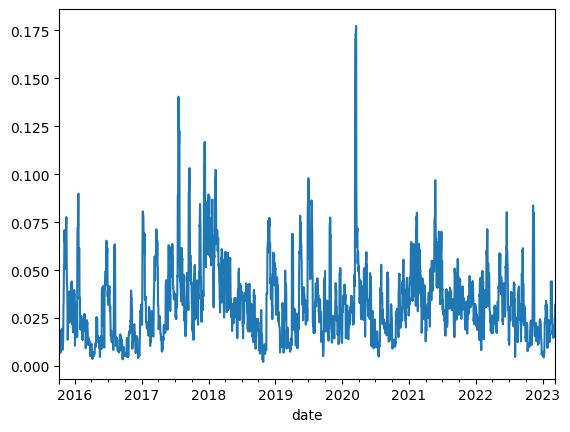

In [12]:
bitcoin_1d['7_day_vol'].plot()

In [16]:
export_path = '/Users/liqingyang/Documents/GitHub/variance_prediction/data/cleaned_data/btc_1d_with_volatilities.csv'
bitcoin_1d.to_csv(export_path)

In [20]:
ar = [0.03] * 700 + [-0.01] * 300
np.array(ar).var() * 252 ** 0.5

0.005333834643106214

In [15]:
bitcoin_1d

,open,high,low,close,Volume BTC,Volume USD,log_return,pct_return,bitcoin_return,MACD,...,ha_open,ha_high,ha_low,150_day_vol,100_day_vol,50_day_vol,30_day_vol,10_day_vol,7_day_vol,5_day_vol
date,,,,,,,,,,,,,,,,,,,,,
2015-10-08,245.00,245.00,243.60,243.95,31.148048,7.611685e+02,-0.004295,-0.004286,0.997147,0.000000,...,NaN,245.000,243.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-09,243.95,249.97,243.60,245.39,56.027841,5.786965e+02,0.005885,0.005903,0.996677,0.114872,...,244.475,249.970,243.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-10,245.39,246.30,244.60,246.30,39.348777,4.024832e+02,0.003702,0.003708,1.001646,0.276155,...,244.670,246.300,244.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-11,246.30,249.50,245.96,249.50,14.487783,1.493239e+02,0.012909,0.012992,1.007784,0.654639,...,245.845,249.500,245.845,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-12,249.50,249.50,247.60,247.60,62.787480,6.484071e+02,-0.007644,-0.007615,1.012993,0.792146,...,247.900,249.500,247.600,NaN,NaN,NaN,NaN,NaN,NaN,0.008229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-07,22441.68,22549.84,21942.00,22211.93,440.863300,4.085653e+05,-0.010290,-0.010238,90.607263,-105.022044,...,22435.010,22549.840,21942.000,0.026727,0.022474,0.025578,0.027008,0.017580,0.019186,0.017833
2023-03-08,22211.93,22307.23,21583.39,21704.40,397.794102,3.653873e+05,-0.023115,-0.022849,89.417862,-191.122415,...,22326.805,22326.805,21583.390,0.026800,0.022565,0.025800,0.027282,0.016855,0.015354,0.010364
2023-03-09,21704.40,21900.00,19300.00,20289.98,1644.085576,1.422081e+06,-0.067388,-0.065167,86.694768,-369.233162,...,21958.165,21958.165,19300.000,0.027304,0.023550,0.027264,0.029303,0.024494,0.024971,0.027898
